In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
color_par = sns.color_palette()


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


## Explore Data

In [3]:
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
data.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [5]:
data.sample()

,Datetime,PJME_MW
40010,2006-06-08 12:00:00,35155.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [7]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)


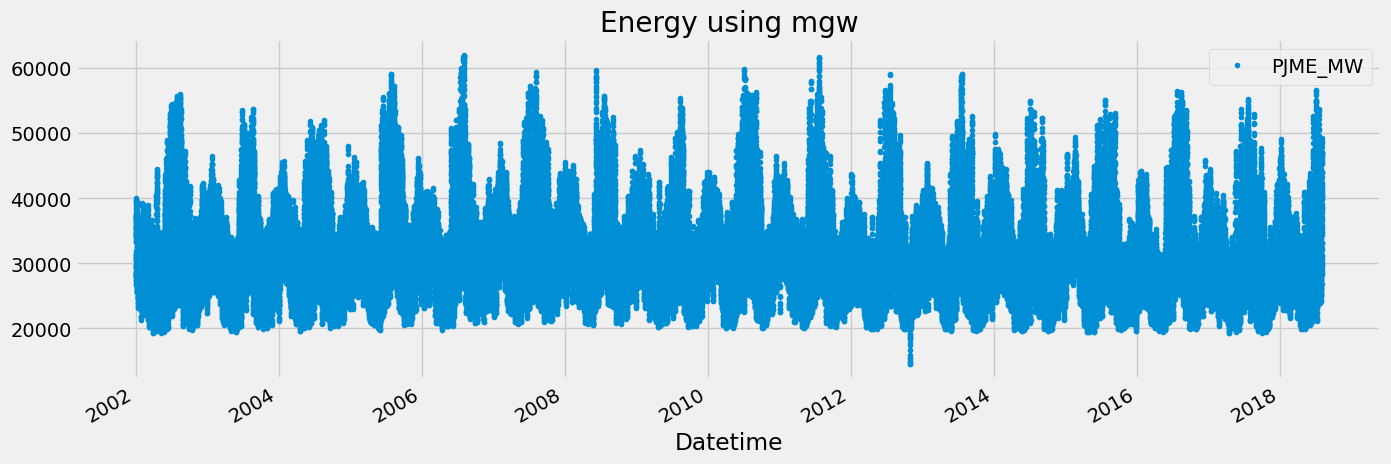

In [8]:
data.plot(figsize=(15,5),style='.',color = color_par[0],title = 'Energy using mgw')
plt.show()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


## Feature Creating

In [10]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['year'] = data.index.year
data['dayofyear'] = data.index.dayofyear


In [11]:
data

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,4,2002,365
2002-12-31 02:00:00,25147.0,2,1,12,4,2002,365
2002-12-31 03:00:00,24574.0,3,1,12,4,2002,365
2002-12-31 04:00:00,24393.0,4,1,12,4,2002,365
2002-12-31 05:00:00,24860.0,5,1,12,4,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


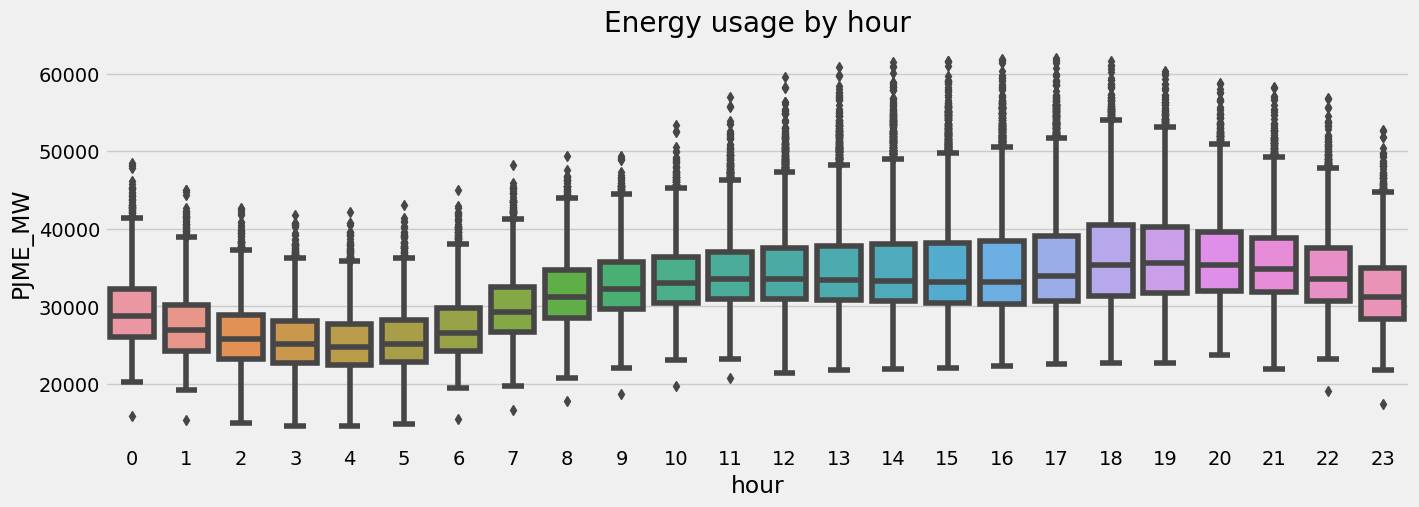

In [12]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data,x='hour',y='PJME_MW')
plt.title('Energy usage by hour')
plt.show()

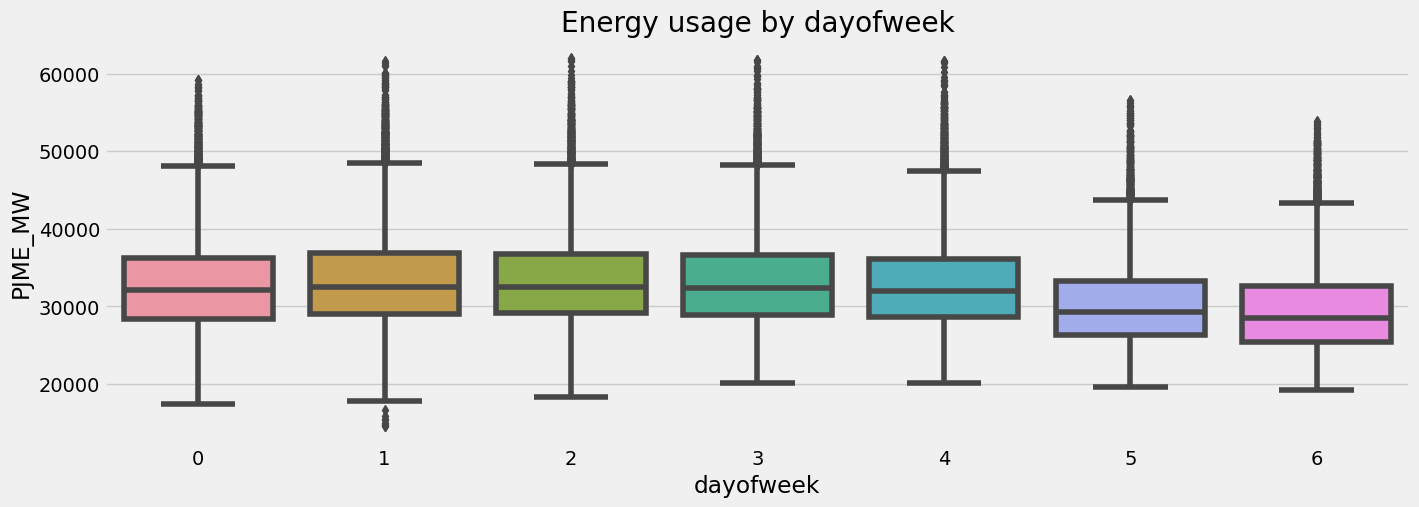

In [13]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data,x='dayofweek',y='PJME_MW')
plt.title('Energy usage by dayofweek')
plt.show()

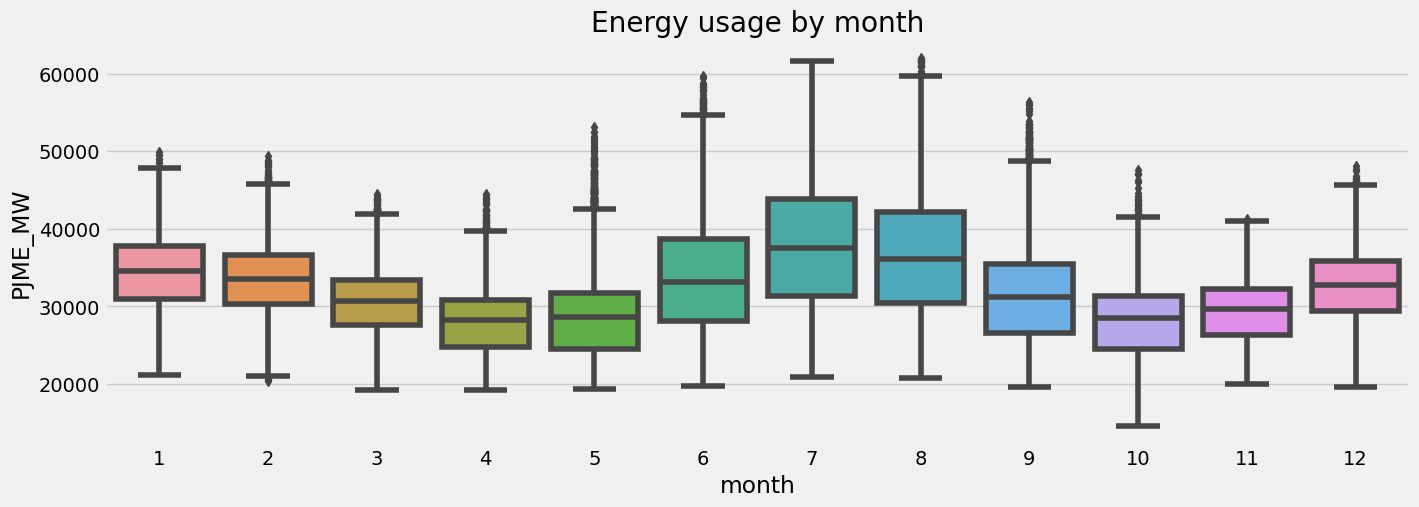

In [14]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data,x='month',y='PJME_MW')
plt.title('Energy usage by month')
plt.show()

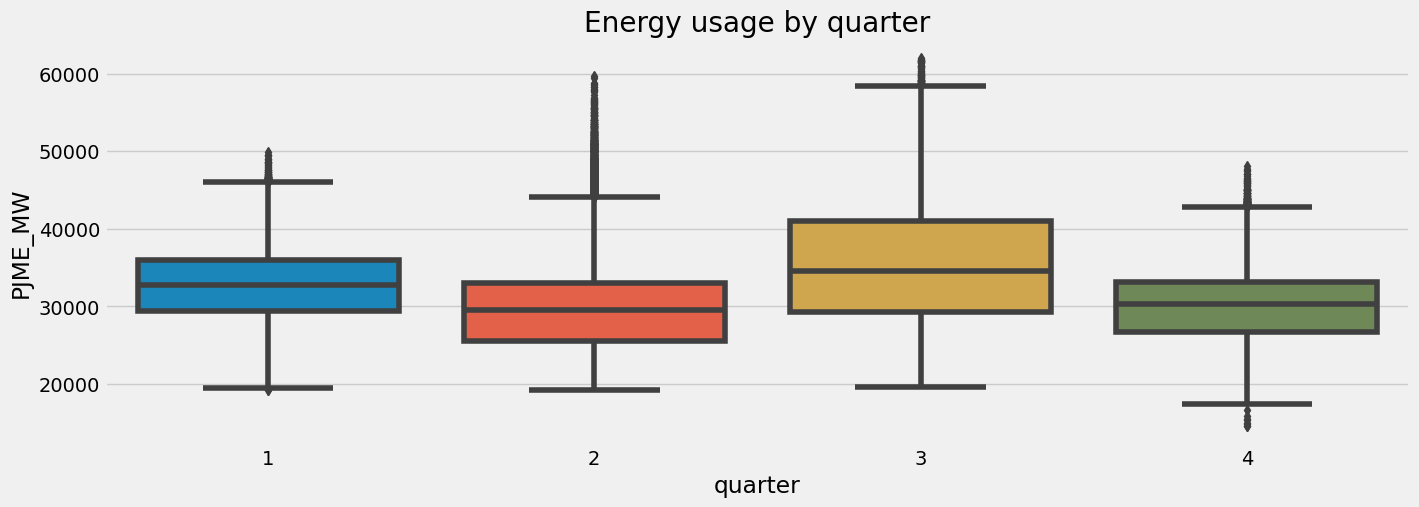

In [15]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data,x='quarter',y='PJME_MW')
plt.title('Energy usage by quarter')
plt.show()

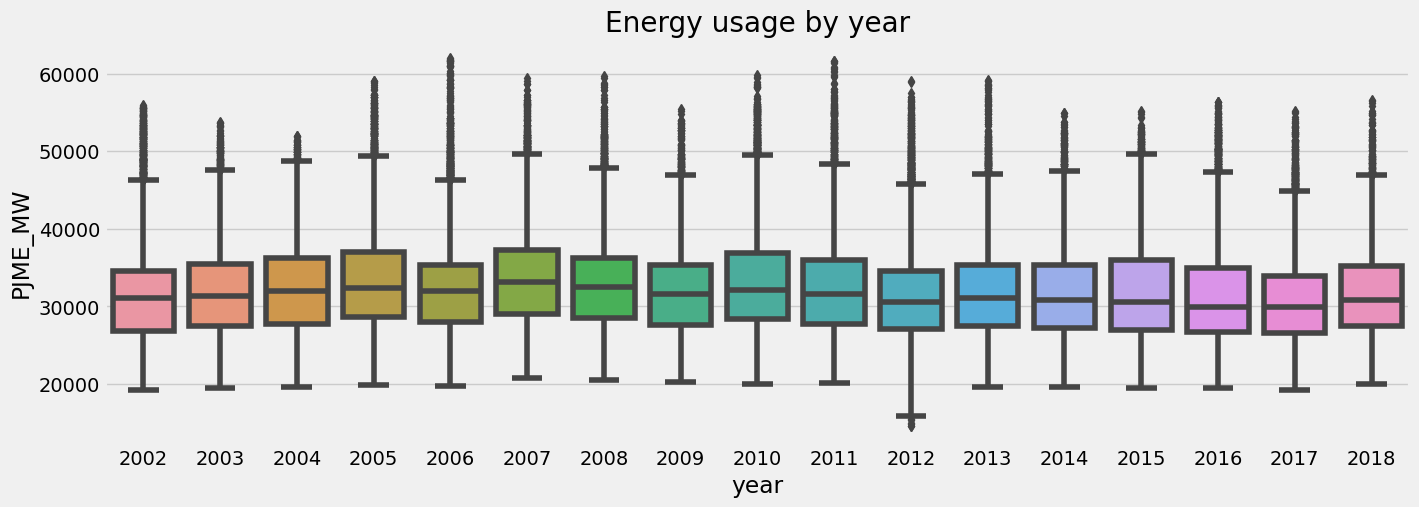

In [16]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data,x='year',y='PJME_MW')
plt.title('Energy usage by year')
plt.show()

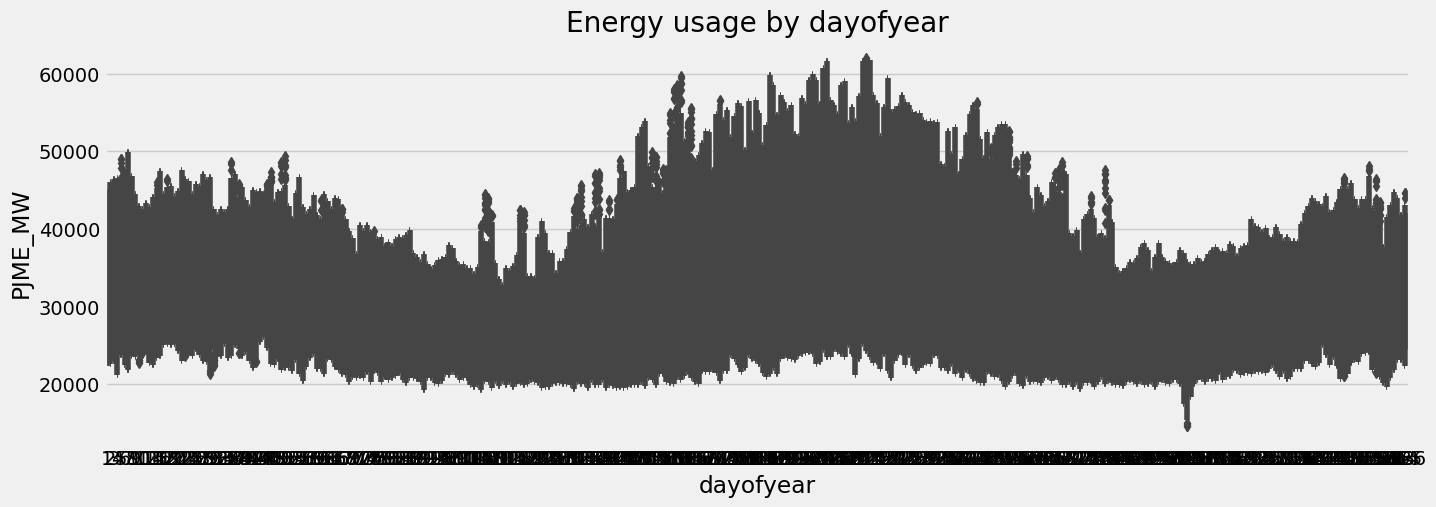

In [17]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data,x='dayofyear',y='PJME_MW')
plt.title('Energy usage by dayofyear')
plt.show()

## model

In [18]:
train_set = data.loc[data.index<'01-01-2015']
test_set = data.loc[data.index>'01-01-2015']

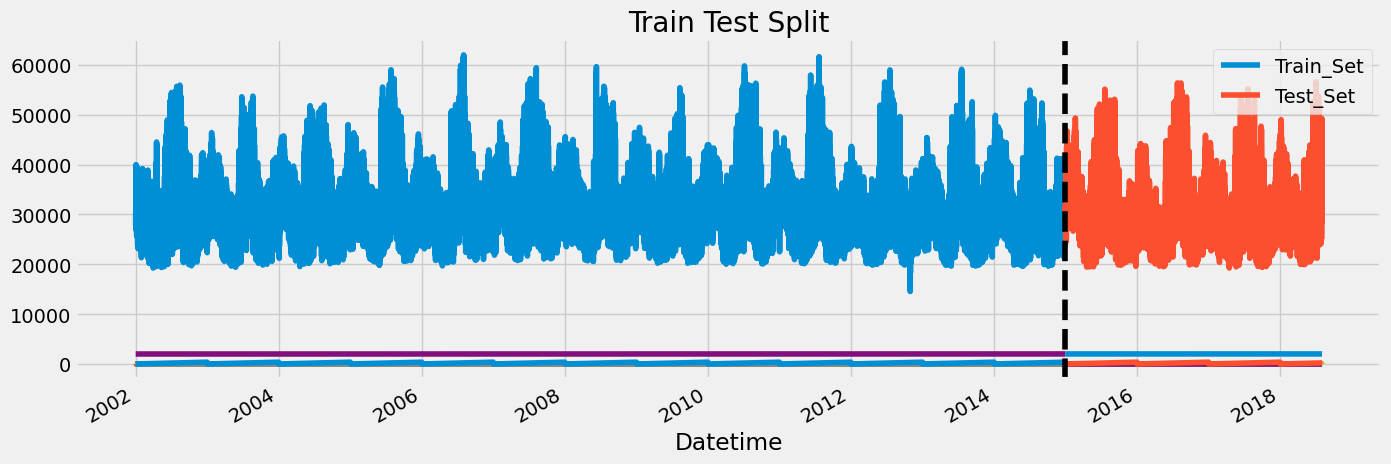

In [19]:
fig,ax = plt.subplots(figsize=(15,5))
train_set.plot(ax=ax)
test_set.plot(ax=ax)
ax.axvline('01-01-2015',color = 'Black',ls = '--')
plt.legend(['Train_Set','Test_Set'])
plt.title('Train Test Split')
plt.show()

In [20]:
x_train = train_set.drop('PJME_MW',axis = 1)
y_train = train_set['PJME_MW']

x_test = test_set.drop('PJME_MW',axis = 1)
y_test = test_set['PJME_MW']


In [21]:
model = GradientBoostingRegressor()
model.fit(x_train,y_train)
a = model.score(x_train,y_train)
b = model.score(x_test,y_test)
print("trina is ",a,"test is ",b)

trina is  0.7770277362870012 test is  0.6642923533046687


In [27]:
pre = model.predict(x_test)
pre

array([28238.7577008 , 27346.01047016, 26911.24146793, ...,
       35299.78720372, 32911.43826502, 31442.24436726])

In [23]:
model.score(x_train,y_train)


0.7770277362870012

In [24]:
model.score(x_test,y_test)

0.6642923533046687

In [28]:
mean_squared_error(pre,y_test)

13965408.981371343

In [26]:
np.sqrt(mean_squared_error(pre,y_test))

3737.032108688838